# Credit Card Customer Segmentation

## Introduction

In this guided project, we’ll play the role of a data scientist working for a credit card company. We've been working on a datset that contains infromation about company's clients. Our job is to help with data segmentation in to groups in order to apply different business strategies for each type of customer.

At a planning meeting with the Data Science coordinator, it was decided that we should use the K-means algorithm to segment the data.

The company expects to receive a group for each customer and an explanation of the characteristics of each group and the main points that differentiate them.

To achive goals that the company has set for us and to use algorithm properly, we'll perform the following steps:
- dataset analysis,
- data preparation for modeling,
- find an appropriate number of clusters,
- data segmentation,
- interpretation and explanation of the results.

In [1]:
# Importing all neccesary libraries
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

## Familiarizing with the dataset

In [2]:
# Read the dataset
data = pd.read_csv('customer_segmentation.csv')

In [3]:
# Check few first rows
data.head()

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000


In [4]:
# Check the size of the dataset
print("Dataset size:", data.shape)

Dataset size: (10127, 14)


Our dataset contains  10,127 rows (observations) and 14 columns (variables/features).

In [5]:
# Check the columns in the dataset
print("Columns:", data.columns)

Columns: Index(['customer_id', 'age', 'gender', 'dependent_count', 'education_level',
       'marital_status', 'estimated_income', 'months_on_book',
       'total_relationship_count', 'months_inactive_12_mon', 'credit_limit',
       'total_trans_amount', 'total_trans_count', 'avg_utilization_ratio'],
      dtype='object')


| column name | description |
| ----------- | ----------- |
|customer_id | unique identifier for each customer |
| age | customer age in years |
| gender | customer gender (M or F) |
| dependent_count | number of dependents of each customer |
| education_level | level of education ("High School", "Graduate", etc.) |
| marital_status | marital status ("Single", "Married", etc.) |
| estimated_income | the estimated income for the customer projected by the data science team |
| months_on_book | time as a customer in months |
| total_relationship_count | number of times the customer contacted the company |
| months_inactive_12_mon | number of months the customer did not use the credit card in the last 12 months |
| credit_limit | customer's credit limit |
| total_trans_amount | the overall amount of money spent on the card by the customer |
| total_trans_count | the overall number of times the customer used the card |
| avg_utilization_ratio | daily average utilization ratio |

In [6]:
# Check the data types of each column
print("Data types:\n", data.dtypes)

Data types:
 customer_id                   int64
age                           int64
gender                       object
dependent_count               int64
education_level              object
marital_status               object
estimated_income              int64
months_on_book                int64
total_relationship_count      int64
months_inactive_12_mon        int64
credit_limit                float64
total_trans_amount            int64
total_trans_count             int64
avg_utilization_ratio       float64
dtype: object


In ouer dataset we have both categorical (dtype: **object**) and numerical (dtype: **int64**, **float**) variables. Categorical variables in the dataset are: 'gender', 'education_level' and 'marital_status'. Lets check how many unique values we have in every categorical variables and how many datapoints per category are there. We can deal with these categorical variables by either one-hot encoding them or using label encoding, we'll see with one to use during our analysis.

In [7]:
for col in ['gender', 'education_level', 'marital_status']:
    print(col)
    print(data[col].value_counts(), end='\n\n')

gender
F    5358
M    4769
Name: gender, dtype: int64

education_level
Graduate         3685
High School      2351
Uneducated       1755
College          1192
Post-Graduate     616
Doctorate         528
Name: education_level, dtype: int64

marital_status
Married     4687
Single      3943
Unknown      749
Divorced     748
Name: marital_status, dtype: int64



In [8]:
# Check for missing values
print("Missing values:\n", data.isnull().sum())

Missing values:
 customer_id                 0
age                         0
gender                      0
dependent_count             0
education_level             0
marital_status              0
estimated_income            0
months_on_book              0
total_relationship_count    0
months_inactive_12_mon      0
credit_limit                0
total_trans_amount          0
total_trans_count           0
avg_utilization_ratio       0
dtype: int64


Also there are no missing values in our dataset.

Because we are working unsupervised machine learning, there isn't a target variable on which we can measure the impacts of the other variables. But we can see the correlation between the numeric variables and their distributions.

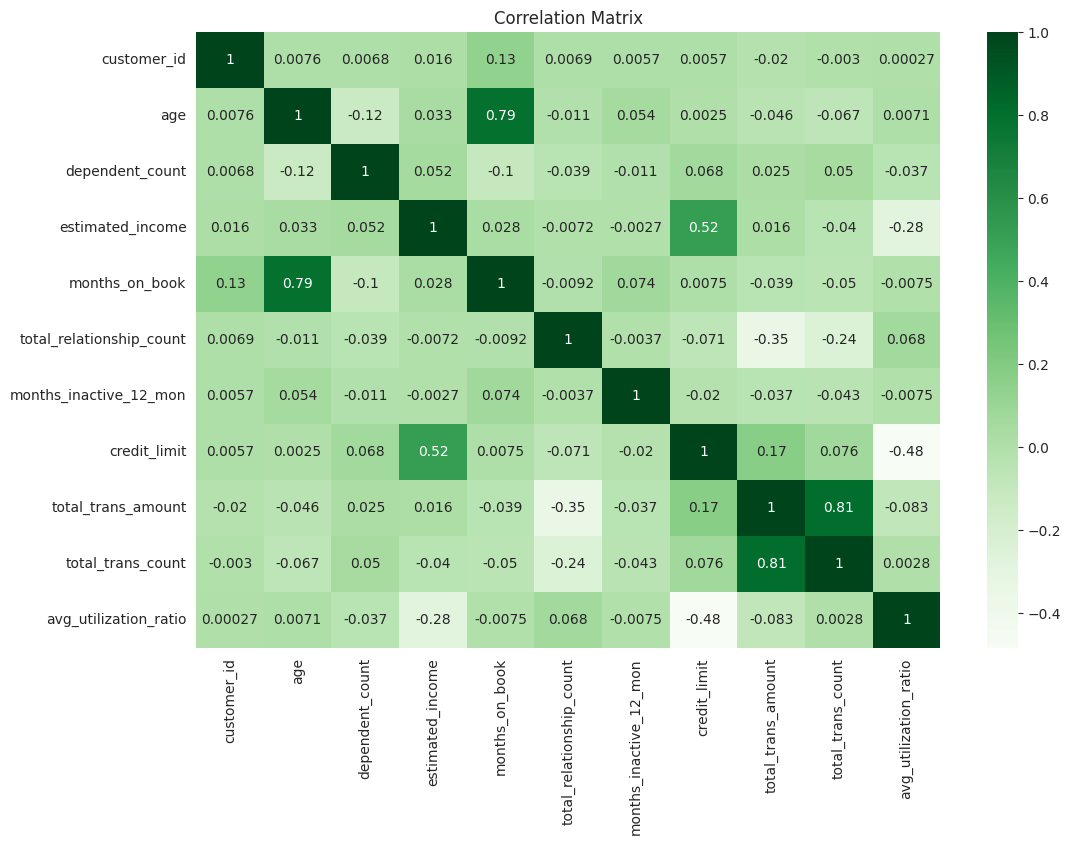

In [9]:
# Calculation the correlation
corr_matrix = data.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="Greens")
plt.title('Correlation Matrix')
plt.show()

The correlation matrix provides insights into the relationships between the numerical variables in the dataset. Here are some observations:
- there are weak correaltion between most of variables,
- age and months on book have a strong positive correlation of 0.78, indicating that older customers tend to have been customers for a longer duration,
- credit limit and estimated income have moderate positive correlation of 0.52, sugesting that customers with higher estimated incomes tend to have higher credit limits,
- credit limit and average utilization ratio have a moderate negative correlation of -0.48, suggesting that customers with higher credit limits tend to have lower average utilization ratios
- total transaction amount and total transaction count have a strong positive correlation of 0.81, indicating that customers who make more transactions tend to have higher transaction amounts,
- total relationship count and total transaction amount have a negative correlation of -0.35, sugesting that customers with more relationships with the company tend to have lower transaction amounts.

Now we're going to see how the distribution of numerical variables look like.

/tmp/ipykernel_3142/1488711469.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  data.drop('customer_id', axis=1).hist(ax=ax)


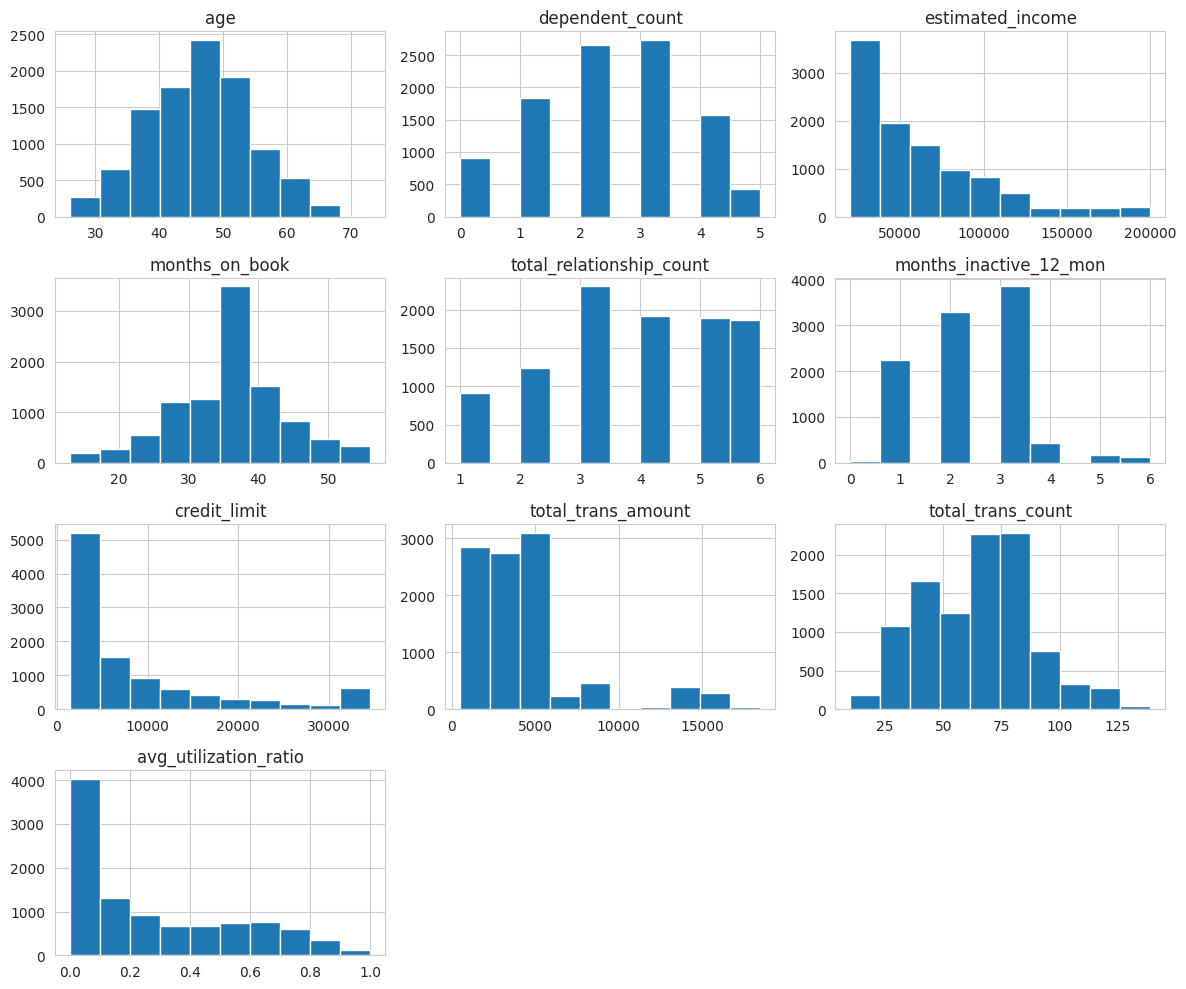

In [10]:
# Plot the distributions
fig, ax = plt.subplots(figsize=(12, 10))

#Removing the customer's id before plotting the distributions
data.drop('customer_id', axis=1).hist(ax=ax)

plt.tight_layout()
plt.show()

In abowe distribution histograms we can see that we have a couple of them closer to a normal distribution, but most of them are skewed. Also we can observed that:
- age distribution is highest between about 35 to 55 years old, withe a peek around 46 years old,
- estimate income is right skewed and larger number of customers have low estimat incomes,
- months on book looks symetrical with peek around 36 months
- credit limit is right skewed and large number of customers have low credit limit but we see that we have increase near the end of the spectrum
- total transaction amout is strongly right skewed 
- total transaction count is weekly right skewed
- average utillization ratio is right skewed
- dependent count is fairly symmetrical
- total relationship count is left skewed and peaks around three
- months inactive 12 months distribution is right skewed and peaks around 3.5.

Now we'll creat plots for categorical data.

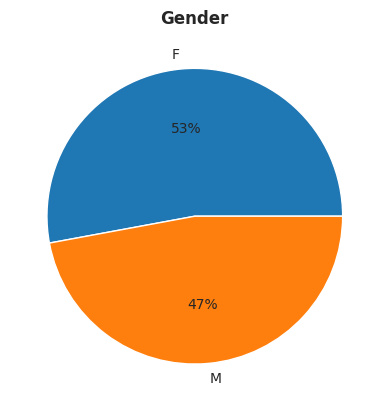

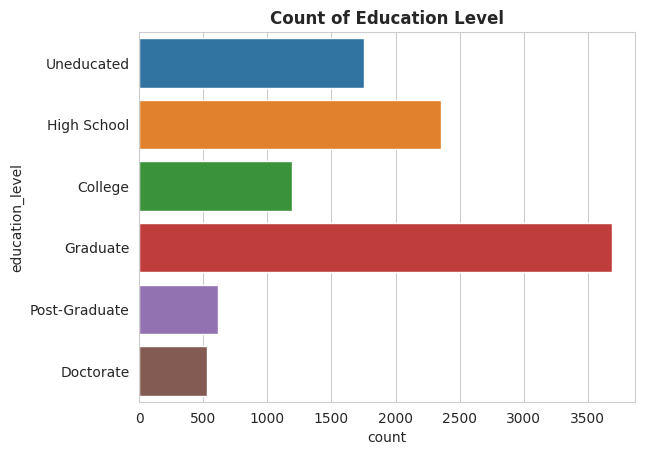

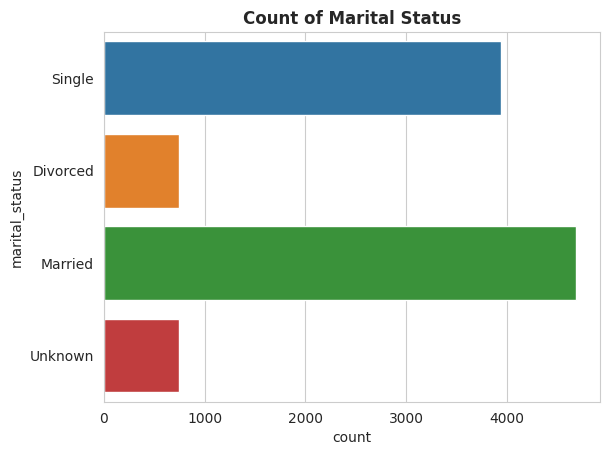

In [11]:
data['gender'].value_counts(normalize=True).plot.pie(autopct='%1.0f%%')
plt.title('Gender', weight = 'bold')
plt.xlabel('')
plt.ylabel('')
plt.show()

order=['Uneducated', 'High School', 'College', 'Graduate', 'Post-Graduate', 'Doctorate']

sns.countplot(data=data, y='education_level', order=order, orient='h')
plt.title('Count of Education Level', weight='bold')
plt.show()

order=['Single', 'Divorced', 'Married', 'Unknown']

sns.countplot(data=data, y='marital_status', order=order,orient='h')
plt.title('Count of Marital Status', weight='bold')
plt.show()

From abowe plots we can conclude:
- dataset are roughly equal with females outnumbering male,
- education level of customers peaks at college graduation,
- single and married are the two largest count in customer's marital status.

## Feature Engineering

Now that we have familiarized ourselves with our dataset let's move on to preparing it for modeling.

First we need to deal with categorical columns: 'gender', 'education level' and 'marital status'. As we saw during our initial analysis 'gender' column contain 2 unique values ('M' and 'F') so we can easly replace it with 1 and 0. In 'education level' we have ther 6 categories which represent level of education so we can rank it from lowes to the higest and replace with numbers:
- Uneducated: 0
- High School: 1
- College: 2
- Graduate: 3
- Post-Graduate: 4
- Doctorate: 5

'Marital status' also have few unique values but we can't easly replace them by numbers, so we will lew it for now and deal with it later.

Befor we do our modification we'll creat a copy of our dataset. We'll leave orginal dataset untouched so we can use it later for results analysis.

In [12]:
# Copy dataset
data_modif = data.copy()

In [13]:
# Replacing values in 'gender' column
data_modif['gender'] = data_modif['gender'].apply(lambda x: 1 if x == 'M' else 0)
data_modif.head()

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,1,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,0,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,1,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000
3,769911858,40,0,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760
4,709106358,40,1,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000


In [14]:
# Replacing values in 'education_level' column
data_modif['education_level'].replace(to_replace = {'Uneducated': 0, 'High School': 1, 'College': 2, 'Graduate': 3,
           'Post-Graduate': 4, 'Doctorate': 5}, inplace=True)
data_modif.head()

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,1,3,1,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,0,5,3,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,1,3,3,Married,93000,36,4,1,3418.0,1887,20,0.000
3,769911858,40,0,4,1,Unknown,37000,34,3,4,3313.0,1171,20,0.760
4,709106358,40,1,3,0,Married,65000,21,5,1,4716.0,816,28,0.000


Now let's deal with 'material status' column. Because here we don't have level of magnitude between 'Single', 'Married', 'Divorced' and 'Unknown' and we can tell witch one is higher or better so we can't replace it using numbers. Changing it that way would be biased and lead to misleading conclusions. Therefore, we'll use one-hot-encoding to create dummy variables from this column.

In [15]:
# Creating dummy variables
dummies = pd.get_dummies(data_modif[['marital_status']], drop_first=True)

# Combaining dummie values with dataset
data_modif = pd.concat([data_modif, dummies], axis=1)

# Droping orginal 'marital status' column
data_modif = data_modif.drop('marital_status', axis=1)

data_modif.head()

,customer_id,age,gender,dependent_count,education_level,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,marital_status_Married,marital_status_Single,marital_status_Unknown
0,768805383,45,1,3,1,69000,39,5,1,12691.0,1144,42,0.061,1,0,0
1,818770008,49,0,5,3,24000,44,6,1,8256.0,1291,33,0.105,0,1,0
2,713982108,51,1,3,3,93000,36,4,1,3418.0,1887,20,0.000,1,0,0
3,769911858,40,0,4,1,37000,34,3,4,3313.0,1171,20,0.760,0,0,1
4,709106358,40,1,3,0,65000,21,5,1,4716.0,816,28,0.000,1,0,0


## Scaling the Data

Befor using K-means algorithm to segment the data we need to scaled our data because we have different scales for columns. To ensure all the features are on the same scale, we'll use the `StandardScaler()` from scikit-learn. To do that we need to take below steps:
1. create a new DataFrame without the column 'customer_id',
0. instantiate an object from the scikit-learn's `StandardScaler()` class and fit it to the new DataFrame.
0. use the `transform` method to scale the data. Assign it to a different variable and print it.
0. convert the scaled data back to a DataFrame using `pd.DataFrame()`.

In [16]:
# Create a new DataFrame without the customer_id column
data_droped_column = data_modif.drop('customer_id', axis=1)

# Instantiate the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the data
scaler.fit(data_droped_column)

# Scale the data using the transform method
data_scaled = scaler.transform(data_droped_column)

# Convert the scaled data back to a DataFrame
data_scaled = pd.DataFrame(data_scaled, columns=data_droped_column.columns)

data_scaled.head()

,age,gender,dependent_count,education_level,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,marital_status_Married,marital_status_Single,marital_status_Unknown
0,-0.165406,1.059956,0.503368,-0.752211,0.175810,0.384621,0.763943,-1.327136,0.446622,-0.959707,-0.973895,-0.775882,1.077338,-0.798507,-0.282609
1,0.333570,-0.943436,2.043199,0.662787,-0.967166,1.010715,1.407306,-1.327136,-0.041367,-0.916433,-1.357340,-0.616276,-0.928214,1.252337,-0.282609
2,0.583058,1.059956,0.503368,0.662787,0.785397,0.008965,0.120579,-1.327136,-0.573698,-0.740982,-1.911206,-0.997155,1.077338,-0.798507,-0.282609
3,-0.789126,-0.943436,1.273283,-0.752211,-0.636973,-0.241473,-0.522785,1.641478,-0.585251,-0.951758,-1.911206,1.759686,-0.928214,-0.798507,3.538459
4,-0.789126,1.059956,0.503368,-1.459710,0.074212,-1.869317,0.763943,-1.327136,-0.430877,-1.056263,-1.570365,-0.997155,1.077338,-0.798507,-0.282609


## Choosing K

After our modification and scaling the dataset is ready for machine learning. The next step is to decide the best number of clusters to use in the segmentation according to the inertia metric.

We'll have to create several models and compute the inertia from each of them. Then, we'll be able to plot the Elbow Curve and decide the number of clusters we'll use to segment the customers. Once we do all that, we can perform the real clusterization.

Below are the steps we must take to prepare for segmentation:
- create an empty list to store the inertia from every model,
- se a for loop to iterate over different numbers of clusters, such as ranging from 1 to 10,
- for each K (number of clusters) in the loop:
    - instantiate a `KMeans()` object and set the number of clusters to K
    - use the `fit_predict()` method to create the clusters
    - append the `inertia_` attribute of the model to the empty list.
- use the list of inertias values to plot the Elbow Curve. The Elbow Curve is a plot of the number of clusters (K) against the inertia. It helps us visualize the trade-off between the number of clusters and the distortion within each cluster. The "elbow" point in the curve indicates the optimal number of clusters where adding more clusters does not significantly improve the inertia,
- based on the Elbow Curve, decide the number of clusters to use for segmenting the customers. This decision should be made by identifying the point in the curve where adding more clusters does not lead to a substantial decrease in inertia,
- instantiate a new `KMeans()` object with the decided number of clusters as K.
- use the `fit_predict()` method on the scaled data to create the final clusters.

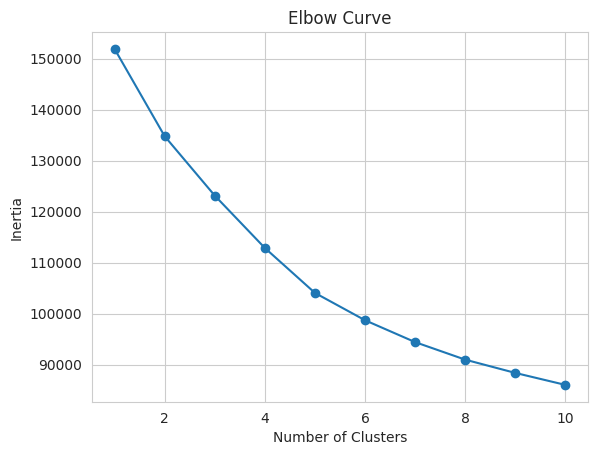

In [17]:
# Empty list to store inertia
inertias = []

# Loop through different numbers of clusters
for i in range (1, 11):
    # Instantiate KMeans with n_clusters=k
    model = KMeans(n_clusters = i)
    
    # Fit the model and create clusters
    clusters = model.fit_predict(data_scaled)
    
    # Append the inertia to the list
    inertias.append(model.inertia_)
    
# Plot the elbow curve
plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Curve')
plt.show()

It looks like the rate of decreasing of the inertia slows down between 6 and 8 clusters. We'll use 7 clusters to move on.

In [18]:
# Based on the elbow curve, decide the number of clusters
num_clusters = 7
print(f"Number of Clusters: {num_clusters}")

# Instantiate KMeans with the decided number of clusters
final_model = KMeans(n_clusters = num_clusters)

# Fit the model and create clusters
final_clusters = final_model.fit_predict(data_scaled)

# Print the outcome
print(final_clusters)

Number of Clusters: 7
[4 1 4 ... 2 6 2]


## Analyzing Results

Now it's time to analyze the results. By examining the variables used in the clustering and their distribution within each cluster, we can gain insights into the different customer segments and make business suggestions accordingly.

In [19]:
# Add CLUSTER column to the original customers DataFrame
data['CLUSTER'] = final_clusters + 1
data.head()

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,CLUSTER
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061,5
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105,2
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000,5
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760,7
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000,5


In [20]:
data['CLUSTER'].value_counts()

3    2165
2    2061
5    1829
6    1268
4    1173
1     903
7     728
Name: CLUSTER, dtype: int64

We can see that cluster 1 is the largest while cluster 4 is the smallest.

Considering the numeric variable only, we'll check on the average value of each variable per cluster. We just need to group the data and plot a bar chart for each column.

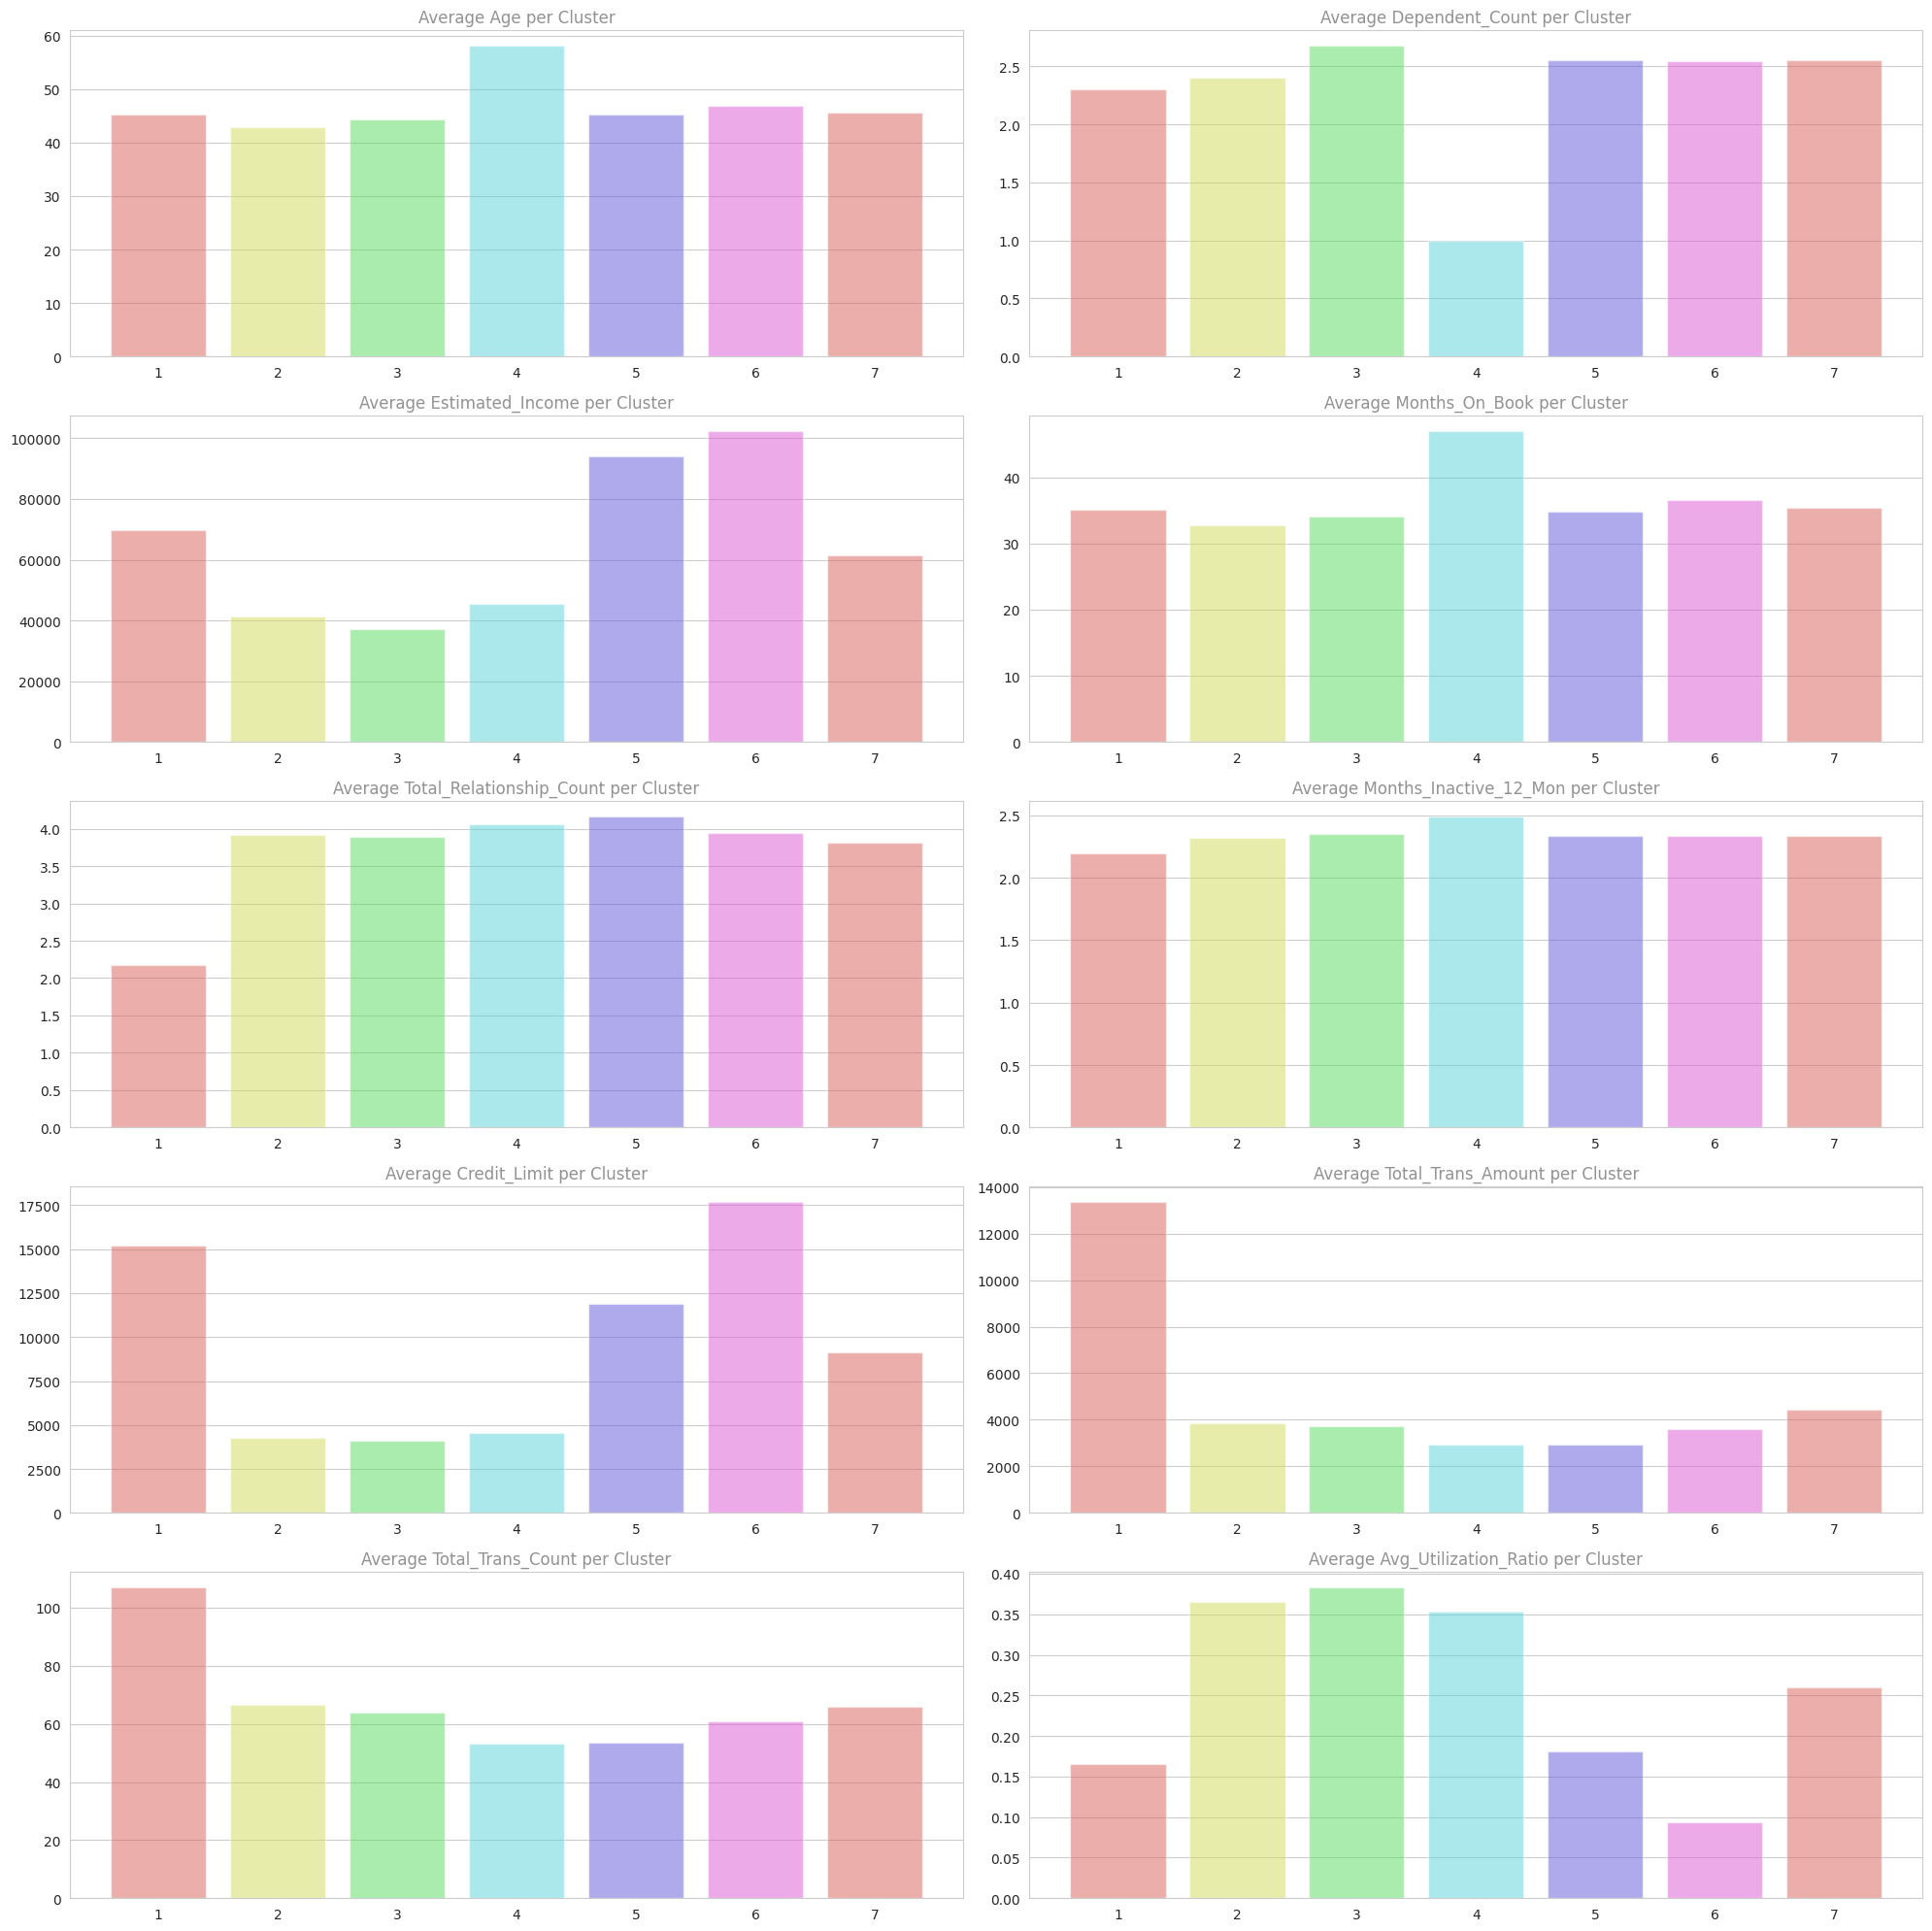

In [21]:
# Group numeric variables by CLUSTER and plot bar charts
numeric_columns = data.select_dtypes(include=np.number).drop(['customer_id', 'CLUSTER'], axis=1).columns

fig = plt.figure(figsize=(20, 20))
for i, column in enumerate(numeric_columns):
    grouped = data.groupby('CLUSTER')[column].mean()
    ax = fig.add_subplot(5, 2, i+1)
    ax.bar(grouped.index, grouped, color=sns.color_palette('hls'), alpha=0.5)
    ax.set_title(f'Average {column.title()} per Cluster', alpha=0.5)
    ax.xaxis.grid(False)
    
plt.tight_layout()
plt.show()

For numerical variables with higher correlations we saw earlier, we can also use a scatter plot to visualize this correlation grouped by clusters and analyze how the clusters change between each area of the chart.

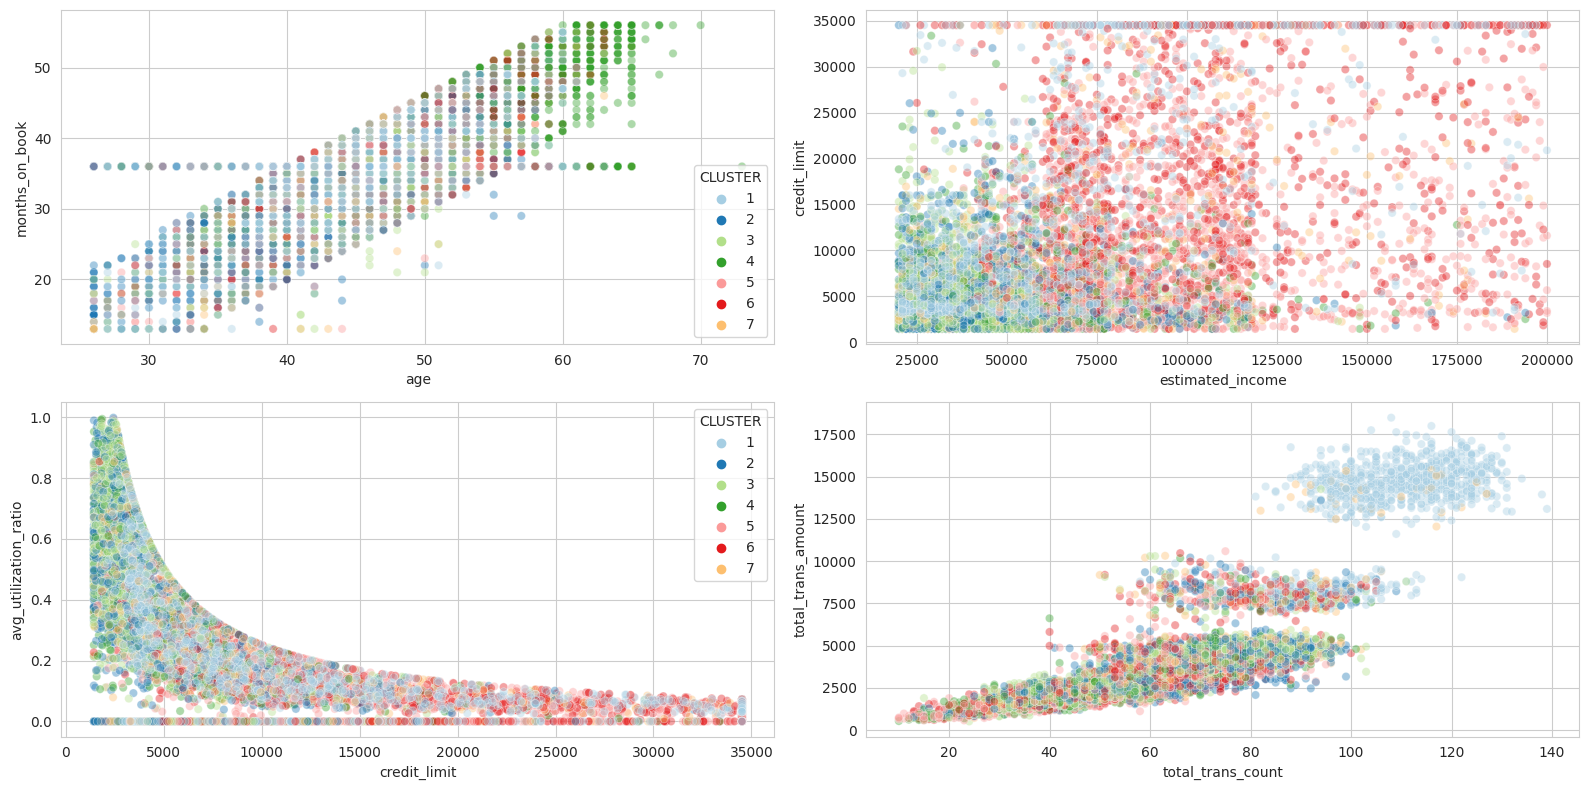

In [22]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 8))
sns.scatterplot(x='age', y='months_on_book', hue='CLUSTER', data=data, palette='Paired', alpha=0.4, ax=ax1)
sns.scatterplot(x='estimated_income', y='credit_limit', hue='CLUSTER', data=data, palette='Paired', alpha=0.4, ax=ax2, legend=False)
sns.scatterplot(x='credit_limit', y='avg_utilization_ratio', hue='CLUSTER', data=data, palette='Paired', alpha=0.4, ax=ax3)
sns.scatterplot(x='total_trans_count', y='total_trans_amount', hue='CLUSTER', data=data, palette='Paired', alpha=0.4, ax=ax4, legend=False)

plt.tight_layout()
plt.show()

For instance, Cluster 1 has the highest amount of money transitioned, while Cluster 3 has the lowest credit limit and estimated income and the highest utilization rate. Cluster 6 has the highest credit limit. Older clients are grouped in Cluster 4.

For the categorical columns, we'll plot the percentual distribution of each variable in each cluster. This will allow us to verify if a particular cluster is mostly composed of men, or of married people only, for example.

/tmp/ipykernel_3142/563962438.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


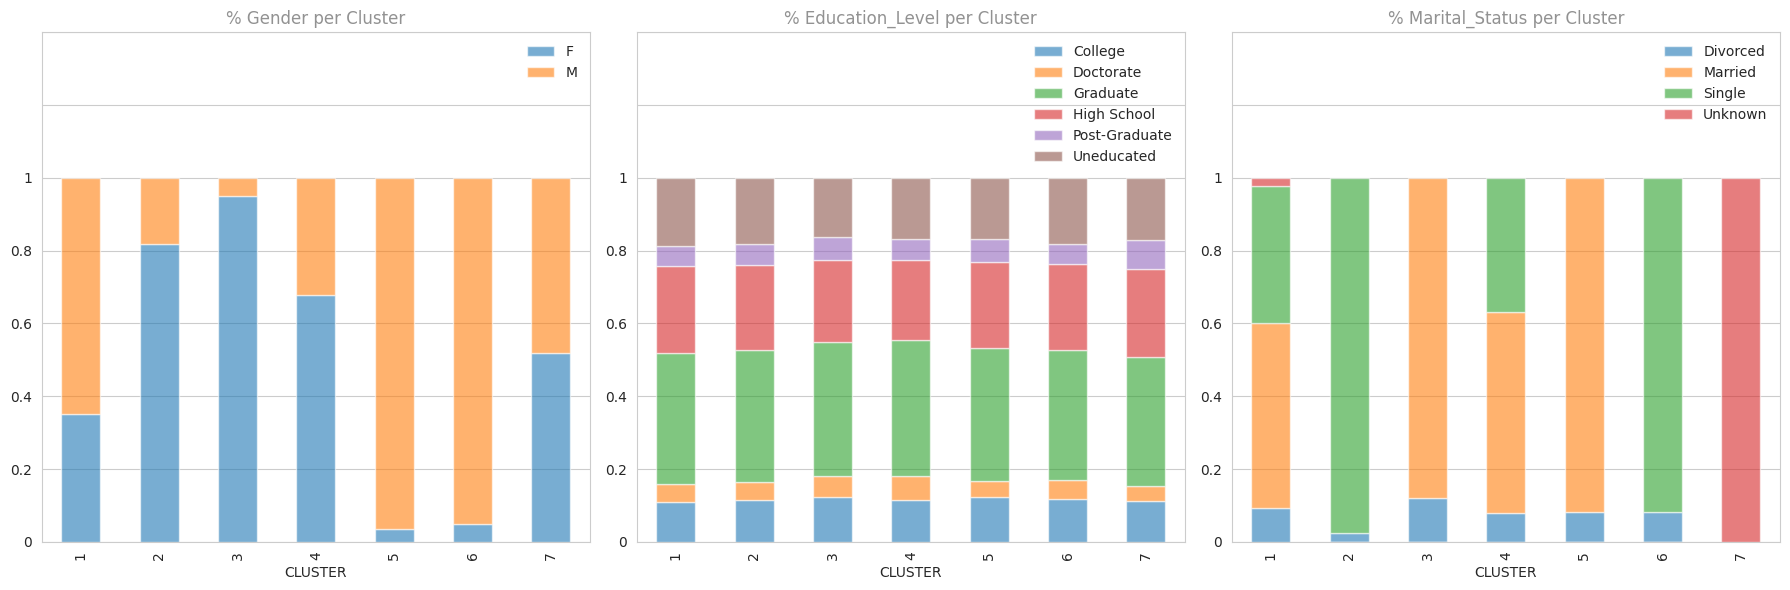

In [25]:
cat_columns = data.select_dtypes(include=['object'])

fig = plt.figure(figsize=(18, 6))
for i, col in enumerate(cat_columns):
    plot_df = pd.crosstab(index=data['CLUSTER'], columns=data[col], values=data[col], aggfunc='size', normalize='index')
    ax = fig.add_subplot(1, 3, i+1)
    plot_df.plot.bar(stacked=True, ax=ax, alpha=0.6)
    ax.set_title(f'% {col.title()} per Cluster', alpha=0.5)

    ax.set_ylim(0, 1.4)
    ax.legend(frameon=False)
    ax.xaxis.grid(False)
    
    labels = [0, 0.2, 0.4, 0.6, 0.8, 1]
    ax.set_yticklabels(labels)

plt.tight_layout()
plt.show()

## Conclusions

We finished segmentation of the data, now it's time to explanati characteristics of each group and the main points that differentiate them.

#### **Cluster 1:**

- **Characteristics:**  Customers in this cluster are mostly men, have an average age of around 45 years. About half are  married. They have the highest amount of money transitioned, low utilization rate, a moderate number of dependents and an estimated income of aroduns 70,000$, high credit limit.

- **Differences from other clusters:** Cluster 1 is characterized by customers with a relatively moderate income level and the highest amount of money transitioned.

- **Business suggestion:** Marketing efforts can focus on offering comprehensive financial planning, offering products and services that meet the needs of a specific group to encourage people to buy more often.

#### **Cluster 2:**

- **Characteristics:** Customers in this cluster are mostly women, have an average age of around 42 years. Most of them are single. They have low amount of money transitioned, low credit limit, high utilization rate, a moderate number of dependents and an estimated income of aroduns 40,000$.

- **Differences from other clusters:** Cluster 2 is characterized by younger customers with a low income level and a higher proportion of singles.

- **Business suggestion:** By recognizing the younger age group in this cluster, marketing campaigns can be tailored to their specific interests and lifestyles.

#### **Cluster 3:**

- **Characteristics:** Customers in this cluster are mostly women, have an average age of around 45 years. Most of them are maried. They have low amount of money transitioned, the lowest credit limit, the highest utilization rate, the highest number of dependents and the lowest estimated income of aroduns 38,000$.

- **Differences from other clusters:** Cluster 3 is characterized by customers with a higher number of dependents, the lowest income level compared to other clusters and the highest number of divorced individuals.

- **Business suggestion** Recognizing the lower income level and the higest number of dependants, marketing strategies can focus on offering affordable financial solutions, savings and investment options, and tailored offers to address the specific needs and aspirations of individuals. Offering financial and banking solutions that cater to the needs of divorced individuals may also be beneficial.

#### **Cluster 4:**

- **Characteristics:** Customers in this cluster are mostly women, have an average age of around 56 years. Most of them are maried. They have low amount of money transitioned, the lowest credit limit, high utilization rate, the lowest number of dependents and an estimated income of aroduns 42,000$.

- **Differences from other clusters:** Cluster 4 is characterized by older customers with the lowest number of dependents and low income level.

- **Business suggestion** Considering the older age demographic in this cluster, marketing strategies can focus on products and services that cater to the needs and preferences of mature customers.

#### **Cluster 5:**

- **Characteristics:** Customers in this cluster are mostly men, have an average age of around 46 years. Most of them are maried. They have low amount of money transitioned, moderate credit limit, low utilization rate, a moderate number of dependents and an estimated income of aroduns 98,000$.

- **Differences from other clusters:** Cluster 5 is characterized by customers with a relatively lower income level compared to other clusters.

- **Business suggestion** Recognizing the lower level of income in this cluster, marketing strategies can focus on affordable solutions, imposing budget and adjusted offers to attract and retain customers. Providing value-added services with competitive pricing can be beneficial.

#### **Cluster 6:**

- **Characteristics:** Customers in this cluster are mostly men, have an average age of around 45 years. Most of them are single. They have low amount of money transitioned, the highest credit limit, the lowest utilization rate, a moderate number of dependents and the gighest estimated income of aroduns 110,000$.

- **Differences from other clusters:** Cluster 6 is characterized by customers with the highest income level and highest level of married customers compared to other clusters.

- **Business suggestion** With higher income levels, this cluster presents an opportunity to offer comprehensive financial planning and investment services. Targeted marketing efforts can focus on providing solutions for the financial well-being of divorced individuals with families.

#### **Cluster 7:**

- **Characteristics:** Customers in this cluster are equally woman and men, have an average age of around 47 years. All of them have maital status unknown. They have low amount of money transitioned, the lowest credit limit, high utilization rate, moderate number of dependents and an estimated income of aroduns 61,000$.

- **Differences from other clusters:** Cluster 7 is characterized by customers with an unknown marital status and a relatively moderate income level.

- **Business suggestion** Since most of the customers in this cluster have unknown marital status, it would be beneficial to conduct targeted marketing campaigns to better understand their needs and preferences. In addition, efforts can be made to collect data on their marital status to further personalize marketing strategies.

Also the company expects to receive a group for each customer, below we have tabel with that informations.

In [27]:
# List of customers and clusters
data[['customer_id', 'CLUSTER']]

,customer_id,CLUSTER
0,768805383,5
1,818770008,2
2,713982108,5
3,769911858,7
4,709106358,5
...,...,...
10122,772366833,1
10123,710638233,2
10124,716506083,3
10125,717406983,7
